In [1]:
import torch
import PIL
from PIL import Image
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from IPython import display
import cv2
import os
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from resizeandpad import ResizeAndPad
from image_enhance import Enhancer
from DataUtils import Loader,ImageToTensor,PrepInput
import torch.nn as nn
import torch.nn.functional as F
from Net import Generator,Disciminator
from tqdm import tqdm

# Image Display/Save Functions


In [2]:
def display_image(image):
    #image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [3]:
def imshow_tensor(img_tensor, title=None):
    """Display a tensor image: CHW → HWC, unnormalize if in [-1,1]"""
    img = img_tensor.clone().detach()     # avoid messing with the original tensor
    img = img * 0.5 + 0.5                  # unnormalize from [-1,1] → [0,1]
    img = img.permute(1, 2, 0)             # CHW → HWC   
    img = img.clamp(0, 1).numpy()                # convert to NumPy

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:


def show_4_images(x,y,img_list, titles=None):
    """
    Display 4 images in a 2x2 grid.
    img_list: list of 4 images (PIL or numpy or torch tensors)
    titles: optional list of 4 titles
    """
    plt.figure(figsize=(10, 8))
    savedir = r"" #Save directory 
    for i, img in enumerate(img_list):
        plt.subplot(2, 2, i + 1)
        
        
        if hasattr(img, "detach"):  
            img = img.detach().cpu()
            if img.ndim == 3:
                img = img * 0.5 + 0.5  # unnormalize if in [-1, 1]
                img = img.permute(1, 2, 0).numpy()  # CHW → HWC
        
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    
    plt.tight_layout()
    plt.savefig(os.path.join(savedir,f"Result_EUVP{x}_{y}.pdf"), dpi=300, bbox_inches='tight',pad_inches=0.02)

    plt.show()
import matplotlib.pyplot as plt



In [ ]:
def show_3_images(x,y,img_list, titles=None):
    """
    Display 3 images in a 1x3 grid.
    img_list: list of 3 images (PIL, numpy, or torch.Tensor)
    titles: optional list of 3 titles
    """
    plt.figure(figsize=(12, 4))
    savedir = r"" #Directory where you want the iamge to be saved.

    for i, img in enumerate(img_list):
        plt.subplot(1, 3, i + 1)

        # Convert torch.Tensor → numpy if needed
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.ndim == 3:
                img = img * 0.5 + 0.5  # unnormalize if [-1,1]
                img = img.permute(1, 2, 0).numpy()  # CHW → HWC

        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(savedir,f"Result{x}_{y}.pdf"), dpi=300, bbox_inches='tight',pad_inches=0.02)

    plt.show()


In [ ]:
def save_model_output(x, y, list_img):
    """
    Save raw input, model output, and reference images 
    into separate subdirectories under Comp_Outputs/DIVE-GAN.
    
    Args:
        x, y: identifiers or indices for filename
        list_img: [raw_img, model_output_img, ref_img] 
                  each can be PIL, numpy, or torch.Tensor
    """
    # Define save directories
    base_dir = r"" #Directory where you want the comparison images to be saved.
    savedir_out = os.path.join(base_dir, "Output")
    savedir_raw = os.path.join(base_dir, "RAW")
    savedir_ref = os.path.join(base_dir, "REF")
    os.makedirs(savedir_out, exist_ok=True)
    os.makedirs(savedir_raw, exist_ok=True)
    os.makedirs(savedir_ref, exist_ok=True)

    def to_pil(img):
        """Convert torch/numpy/PIL image to PIL.Image"""
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.ndim == 3:
                img = img * 0.5 + 0.5  # unnormalize if in [-1, 1]
                img = img.permute(1, 2, 0).numpy()  # CHW → HWC
            img = (img * 255).clip(0, 255).astype('uint8')
            return Image.fromarray(img)
        elif isinstance(img, np.ndarray):
            if img.max() <= 1.0:
                img = (img * 255).clip(0, 255).astype('uint8')
            return Image.fromarray(img)
        elif isinstance(img, Image.Image):
            return img
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

    # Unpack the images
    raw_img, model_output_img, ref_img = list_img

    # Convert all to PIL
    raw_pil = to_pil(raw_img)
    output_pil = to_pil(model_output_img)
    ref_pil = to_pil(ref_img)

    # Common filename pattern
    filename = f"Result_{x}_{y}.png"
    filenameref = f"Ref_{x}_{y}.png"
    filenameraw = f"Raw_{x}_{y}.png"

    # Save each image in its folder
    raw_pil.save(os.path.join(savedir_raw, filenameraw))
    output_pil.save(os.path.join(savedir_out, filename))
    ref_pil.save(os.path.join(savedir_ref, filenameref))


# Model Init/ Train Pipeline

In [ ]:
path = r"dataset\modified\RAW" #Dataset generated after executing gen_dataset.py
ref_path = r"dataset\modified\REF"
dl = Loader(batch_size=8,train_split=.8)
dl(path,ref_path)


In [8]:
from loss_functions import GANLoss_Multi,GANLoss_Single

In [9]:
prep = PrepInput("cuda")

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
gen = Generator().to(device)
disc = Disciminator().to(device)

In [12]:
gLoss = GANLoss_Multi(lambda_pixel=.5,lambda_perc=.25,device=device)
#gLoss = GANLoss_Single(lambda_pixel=.5,device=device)


In [13]:
#Init Optimizers

disc_optim = torch.optim.Adam(disc.parameters(),lr=5e-5)
gen_optim = torch.optim.Adam(gen.parameters(),lr=2e-4)



In [14]:
from tqdm import tqdm
import datetime

def log_step(msg, step=None, total=None, prefix=None):
    """
    Logs a message above the tqdm progress bar without interfering with it.

    Args:
        msg (str): Message to print
        step (int, optional): Current step number
        total (int, optional): Total number of steps
        prefix (str, optional): Prefix like '✓', '[INFO]', etc.
    """
    timestamp = datetime.datetime.now().strftime("%H:%M:%S")
    bar = ""
    if step is not None and total is not None:
        bar = f"[{step}/{total}]"
    if prefix:
        prefix = f"{prefix} "
    else:
        prefix = ""

    tqdm.write(f"{prefix}{bar} [{timestamp}] {msg}")


In [15]:
val_raw,val_ref = dl.get_item(0)
val_combined, val_raw_s, val_ref_s, val_p1, val_p2, val_p3 = prep(val_raw, val_ref)

test_input = val_combined[0].unsqueeze(0)
test_raw = val_raw_s[0].unsqueeze(0)
val_ref = val_ref_s[0].unsqueeze(0)
p1 = val_p1[0].unsqueeze(0)
p2 = val_p2[0].unsqueeze(0)
p3 = val_p3[0].unsqueeze(0)
print(test_input.shape,test_raw.shape,val_ref.shape,p1.shape,p2.shape,p3.shape)
print(torch.max(val_ref))

torch.Size([1, 12, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 6, 256, 256]) torch.Size([1, 6, 256, 256]) torch.Size([1, 6, 256, 256])
tensor(0.9451, device='cuda:0')


In [16]:
import torchvision.utils as vutils
import os
from PIL import Image
import torch
import torchvision.transforms as T

def save_sample_output(epoch, batch_idx, raw_tensor, gen_tensor, gt_tensor, save_dir="outputs"):
    os.makedirs(save_dir, exist_ok=True)
    
    # De-normalize if you normalized to [-1, 1]
    def denorm(t):
        return (t * 0.5) + 0.5

    raw_img = denorm(raw_tensor.cpu().detach().clone())
    gen_img = denorm(gen_tensor.cpu().detach().clone())
    gt_img = denorm(gt_tensor.cpu().detach().clone())
    
    # Make a grid
    img_grid = vutils.make_grid(torch.cat([raw_img, gen_img, gt_img], dim=0), nrow=3,padding=2)

    # Save as image
    vutils.save_image(img_grid, f"{save_dir}/epoch{epoch+1}_batch{batch_idx}.png")


In [17]:
def save_model(model, epoch, batch, kind="gen", base_dir="model_weights"):
    """
    Saves model weights into separate folders for generator and discriminator.

    Args:
        model (torch.nn.Module): The model to save.
        epoch (int): Current epoch number.
        batch (int): Current batch number.
        kind (str): 'gen' or 'disc' to decide folder placement.
        base_dir (str): Root directory for saving weights.
    """
    # Pick subfolder based on kind
    if kind == "gen":
        save_dir = os.path.join(base_dir, "generator")
    elif kind == "disc":
        save_dir = os.path.join(base_dir, "discriminator")
    else:
        raise ValueError("kind must be 'gen' or 'disc'")

    os.makedirs(save_dir, exist_ok=True)

    # Filename format
    filename = f"{kind}_epoch{epoch+1}_batch{batch}.pth"
    filepath = os.path.join(save_dir, filename)

    # Save weights
    torch.save(model.state_dict(), filepath)
    print(f"✓ Saved {kind} model weights at {filepath}")



In [18]:
from torch.amp import GradScaler,autocast
import sys 
import time
from IPython.display import clear_output

scaler_gen = GradScaler()
scaler_disc = GradScaler()

epochs = 20

gen_loss = []
disc_loss = []
adv_loss = []
perc_loss = []
pix_loss = []

for epoch in (range(epochs)):
    gen.train()
    disc.train()
    print(f"Epoch = {epoch + 1}/{epochs}")
    batch_loss_gen = []
    batch_adv_loss = []
    batch_pixel_loss = []
    batch_percept_loss = []
    batch_loss_disc = []
    total = len(dl.train_set)
    for i in range(total):
        #print(f"Batch: {i+1}")
        start_batch = time.time()

        raw,ref = dl.get_item(i)

        combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)
        
       
        with autocast(device_type=device):
            fake = gen(combined,pair1,pair2,pair3)
            fake_det = fake.detach()

            pred_real = disc(raw_s,ref_s)
            pred_fake = disc(raw_s,fake_det)
            log_step("Discriminator  Forward step complete", step=i+1, total=total, prefix="✓")

            loss_d,_ = gLoss.compute_disc_loss(pred_real,pred_fake)

        batch_loss_disc.append(loss_d.item())
        


        disc_optim.zero_grad()
        scaler_disc.scale(loss_d).backward()
        scaler_disc.step(disc_optim)
        scaler_disc.update()

        log_step("Discriminator backprop complete", step=i+1, total=total, prefix="✓")


        #train generator
        
        with autocast(device_type=device):
            fake = gen(combined,pair1,pair2,pair3)
            pred_fake = disc(raw_s,fake)
            log_step("Generator Forward step complete", step=i+1, total=total, prefix="✓")

            gloss,other_losses= gLoss.compute_gen_loss(fake,pred_fake,ref_s)
        batch_loss_gen.append(gloss.item())
        batch_adv_loss.append(other_losses['adv_loss'])
        batch_percept_loss.append(other_losses['perc_loss'])
        batch_pixel_loss.append(other_losses['pixel_loss'])




        gen_optim.zero_grad()
        scaler_gen.scale(gloss).backward()
        scaler_gen.step(gen_optim)
        scaler_gen.update()

        #print("Backprop in gen done")
        log_step("Generator backprop complete", step=i+1, total=total, prefix="✓")

        if(i%20 == 0):
            gen.eval()
            val_fake = gen(test_input,p1,p2,p3)
            print(val_fake.shape,test_raw.shape,val_ref.shape)
            save_sample_output(epoch,i,test_raw,val_fake,val_ref)
            save_model(gen,epoch,batch=i,kind="gen")
            save_model(disc,epoch,batch=i,kind="disc")

            log_step("Output Saved.")

        clear_output(wait=True)
        batch_time = time.time() - start_batch
        progress = (i + 1) / total * 100
        
        gen_loss_val = batch_loss_gen[-1] if batch_loss_gen else 0
        disc_loss_val = batch_loss_disc[-1] if batch_loss_disc else 0
        
        status = f"\rEpoch {epoch+1} [{i+1:3d}/{total}] ({progress:5.1f}%) | "
        status += f"Gen: {gen_loss_val:.4f} | Disc: {disc_loss_val:.4f} | "
        status += f"Time: {batch_time:.2f}s/batch"
        
        tqdm.write(status)
        #sys.stdout.flush()
        

        del fake, fake_det, pred_real, pred_fake, loss_d, gloss


    torch.cuda.empty_cache()
    gen_loss.append(np.mean(batch_loss_gen))
    disc_loss.append(np.mean(batch_loss_disc))
    adv_loss.append(np.mean(batch_adv_loss))
    pix_loss.append(np.mean(batch_pixel_loss))
    perc_loss.append(np.mean(batch_percept_loss))

    

    print(f"Epoch {epoch+1} - Gen Loss: {gen_loss[-1]:.4f}, Disc Loss: {disc_loss[-1]:.4f}\n")

        

Epoch 20 [ 90/90] (100.0%) | Gen: 2.7501 | Disc: 0.0975 | Time: 0.57s/batch
Epoch 20 - Gen Loss: 1.8915, Disc Loss: 0.1507



In [19]:
from typing import List

def plot_gan_losses(
    gen_losses: List[float],
    disc_losses: List[float],
    pixel_losses: List[float],
    perc_losses: List[float],
    adv_losses: List[float],
    save_path: str = "gan_loss_plot.pdf"
):
    """
    Plots generator, discriminator, and component losses in a 2x2 grid.

    Args:
        gen_losses (List[float]): A list of total generator loss values.
        disc_losses (List[float]): A list of total discriminator loss values.
        pixel_losses (List[float]): A list of pixel loss values.
        perc_losses (List[float]): A list of perceptual loss values.
        adv_losses (List[float]): A list of adversarial loss values.
        save_path (str): The path where the plot image will be saved.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    
    fig.suptitle("GAN Training Loss Components", fontsize=20, fontweight='bold')

   
    axs[0, 0].plot(gen_losses, label='Generator Loss', color='dodgerblue', linewidth=2)
    axs[0, 0].plot(disc_losses, label='Discriminator Loss', color='crimson', linewidth=2)
    axs[0, 0].set_title("Overall GAN Losses", fontsize=14)
    axs[0, 0].set_ylabel("Loss Value", fontsize=12)
    axs[0, 0].legend()
    axs[0, 0].set_ylim(bottom=0)

    
    axs[0, 1].plot(pixel_losses, label='Pixel Loss', color='mediumseagreen', linewidth=2)
    axs[0, 1].set_title("Pixel Loss", fontsize=14)
    axs[0, 1].set_ylabel("Loss Value", fontsize=12)
    axs[0, 1].legend()
    axs[0, 1].set_ylim(bottom=0)

   
    axs[1, 0].plot(perc_losses, label='Perceptual Loss', color='darkorange', linewidth=2)
    axs[1, 0].set_title("Perceptual Loss", fontsize=14)
    axs[1, 0].set_xlabel("Training Steps (or Epochs)", fontsize=12)
    axs[1, 0].set_ylabel("Loss Value", fontsize=12)
    axs[1, 0].legend()
    axs[1, 0].set_ylim(bottom=0)

   
    axs[1, 1].plot(adv_losses, label='Adversarial Loss', color='darkviolet', linewidth=2)
    axs[1, 1].set_title("Adversarial Loss", fontsize=14)
    axs[1, 1].set_xlabel("Epochs", fontsize=12)
    axs[1, 1].set_ylabel("Loss Value", fontsize=12)
    axs[1, 1].legend()
    axs[1, 1].set_ylim(bottom=0)

    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Detailed loss plot saved to: {save_path}")
    
    plt.show()


Detailed loss plot saved to: gan_loss_plot.pdf


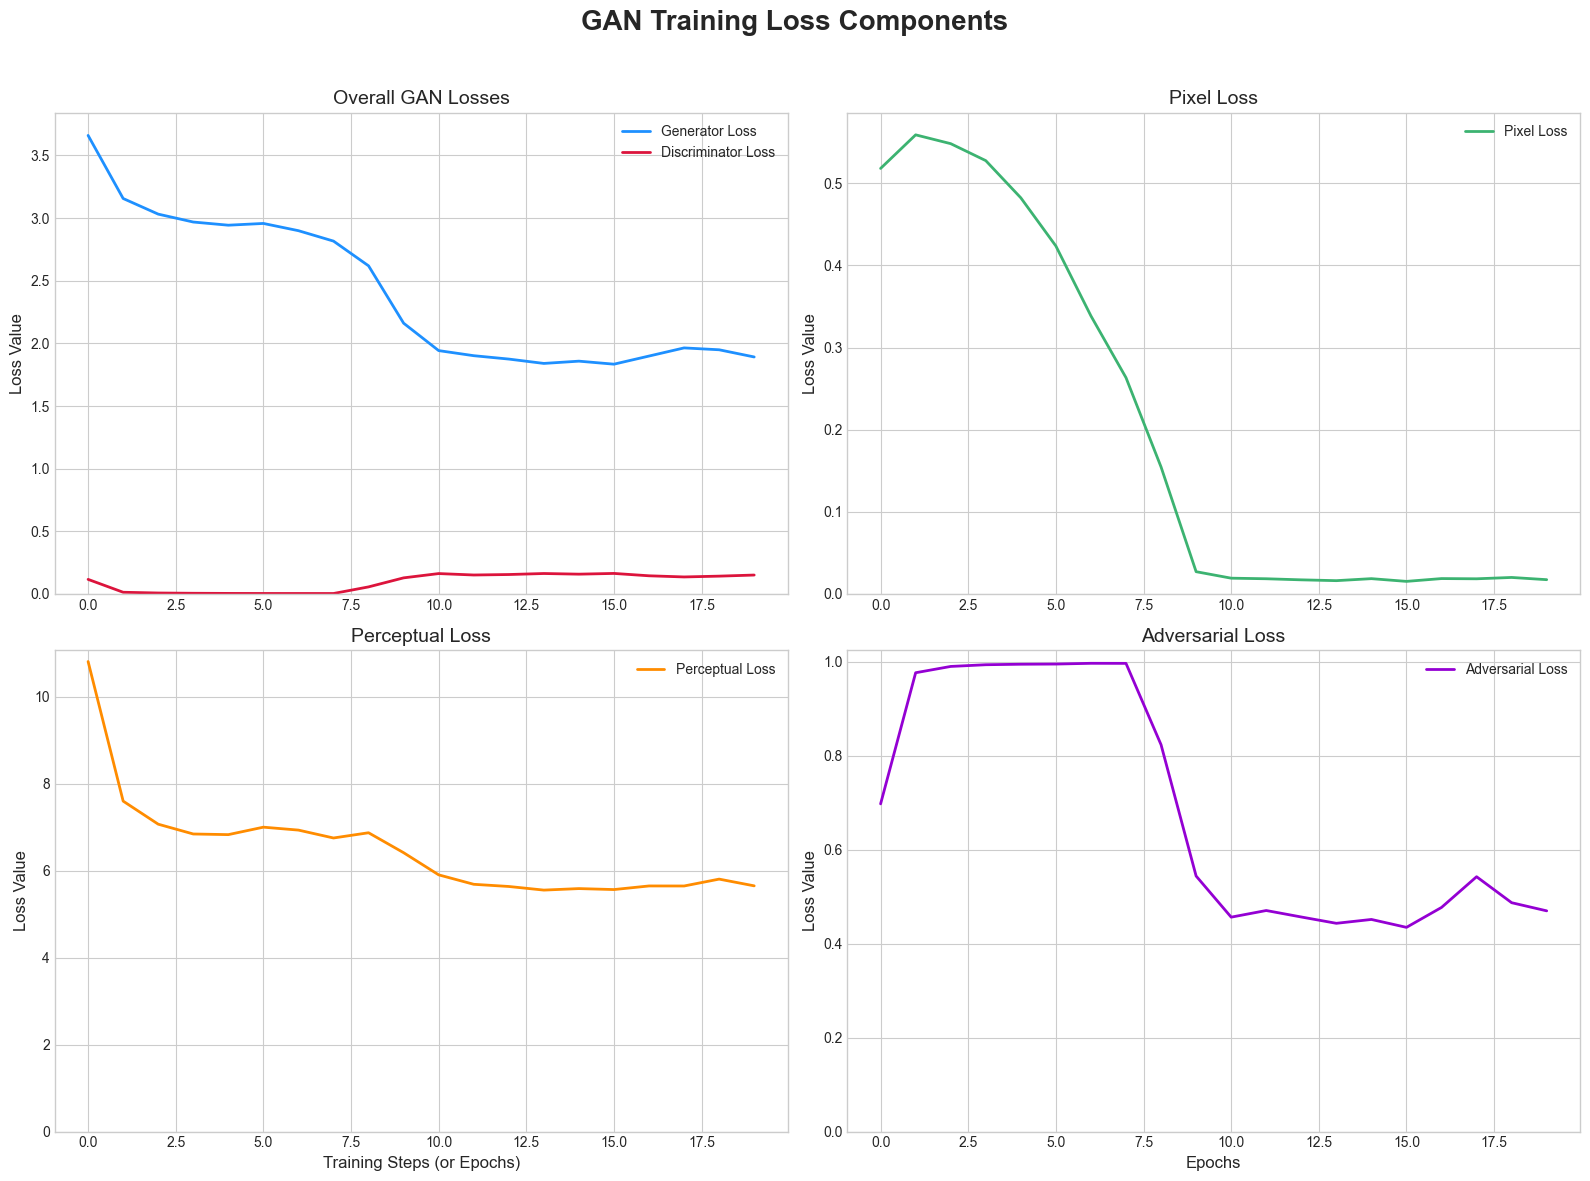

In [20]:
plot_gan_losses(gen_loss,disc_loss,pix_loss,perc_loss,adv_loss)

# Display/Save Outputs

11 2


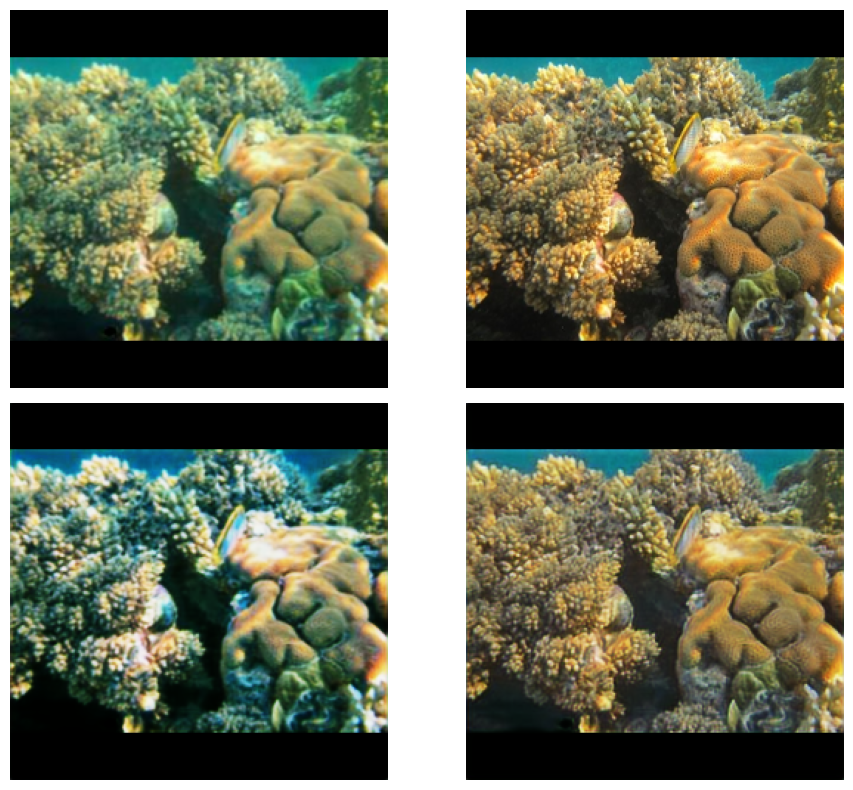

In [ ]:
#MAKE SURE TO USE THE RIGHT PATHS HERE
import random
j = random.randint(0,21)

raw,ref = dl.get_item(j,train=False)
combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)

i = random.randint(0,7)


gen1 = Generator().to(device)
gen2 = Generator().to(device)
gen1.load_state_dict(torch.load(r"",map_location=device))
gen2.load_state_dict(torch.load(r"",map_location=device))
gen1.eval()
gen2.eval()
c = combined[i].unsqueeze(0)
p1 = pair1[i].unsqueeze(0)
p2 = pair2[i].unsqueeze(0)
p3 =  pair3[i].unsqueeze(0)
output_12 = gen1(c,p1,p2,p3).squeeze(0)
output_other = gen2(c,p1,p2,p3).squeeze(0)



print(j,i)

show_4_images(i,j,[raw_s[i].cpu(),ref_s[i].cpu(),output_12.cpu(),output_other.cpu()])

12 4


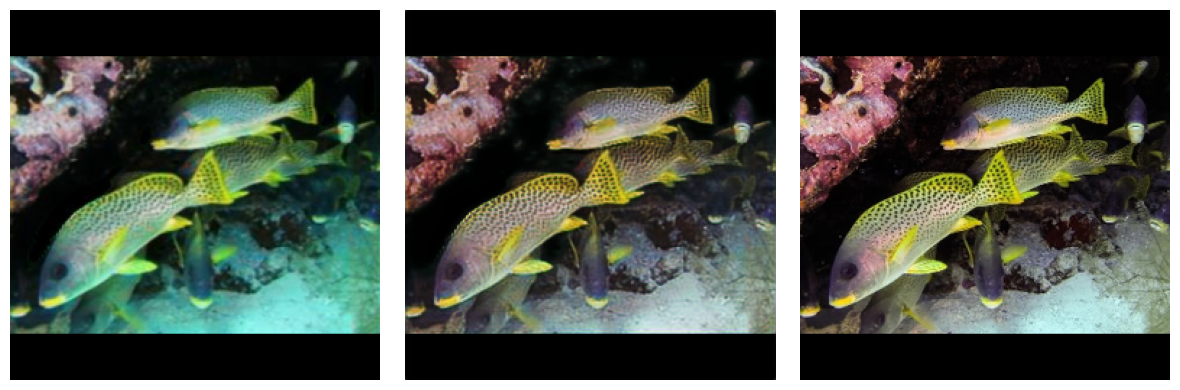

In [ ]:
import random
j = random.randint(0,21)

raw,ref = dl.get_item(j,train=False)
combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)

i = random.randint(0,7)


gen1 = Generator().to(device)
gen1.load_state_dict(torch.load(r"",map_location=device)) #Where your Generator Model's Weights are saved.
gen1.eval()
c = combined[i].unsqueeze(0)
p1 = pair1[i].unsqueeze(0)
p2 = pair2[i].unsqueeze(0)
p3 =  pair3[i].unsqueeze(0)
output_gen1 = gen1(c,p1,p2,p3).squeeze(0)



print(j,i)


show_3_images(i,j,[raw_s[i].cpu(),output_gen1.cpu(),ref_s[i].cpu()])


In [ ]:
#MAKE SURE TO USE THE RIGHT PATHS HERE 
for j in range(21):
    raw,ref = dl.get_item(j,train=False)
    combined,raw_s,ref_s,pair1,pair2,pair3 = prep(raw,ref)
    
    for i in range(8):


        gen1 = Generator().to(device)
        gen1.load_state_dict(torch.load(r"",map_location=device)) #Where the Generator Model's weights are saved.
        gen1.eval()
        c = combined[i].unsqueeze(0)
        p1 = pair1[i].unsqueeze(0)
        p2 = pair2[i].unsqueeze(0)
        p3 =  pair3[i].unsqueeze(0)
        output_gen1 = gen1(c,p1,p2,p3).squeeze(0)




        save_model_output(i,j,[raw_s[i].cpu(),output_gen1.cpu(),ref_s[i].cpu()])

# Model Evaluation

In [40]:
from torchmetrics.functional import structural_similarity_index_measure, peak_signal_noise_ratio


def evaluate_model(model, device):
    model.to(device)
    model.eval()

    mse_loss = nn.MSELoss()

    total_mse = 0.0
    total_ssim = 0.0
    total_psnr = 0.0
    total_images = 0  

    with torch.no_grad():
        total = len(dl.test_set)
        for i in tqdm(range(total), desc="Evaluating Model"):
            raw, ref = dl.get_item(i, train=False)
            combined, raw_s, ref_s, pair1, pair2, pair3 = prep(raw, ref)

            model_output = model(combined, pair1, pair2, pair3)

            model_output = (model_output + 1.0) / 2.0
            ref_s = (ref_s + 1.0) / 2.0

          
            batch_size = model_output.shape[0]

           
            batch_mse = mse_loss(model_output, ref_s)
            batch_ssim = structural_similarity_index_measure(model_output, ref_s, data_range=1.0)
            batch_psnr = peak_signal_noise_ratio(model_output, ref_s, data_range=1.0)

           
            total_mse += batch_mse.item() * batch_size
            total_ssim += batch_ssim.item() * batch_size
            total_psnr += batch_psnr.item() * batch_size
            total_images += batch_size

    
    avg_mse = total_mse / total_images
    avg_ssim = total_ssim / total_images
    avg_psnr = total_psnr / total_images

    print(f"Processed {total_images} images total")
    print(f"Results: MSE={avg_mse:.6f}, SSIM={avg_ssim:.4f}, PSNR={avg_psnr:.2f}")

    return {'MSE': avg_mse, 'SSIM': avg_ssim, 'PSNR': avg_psnr}
      
            

In [ ]:
res = evaluate_model(gen1,device)
res2 = evaluate_model(gen2,device)

# Save Dataset
 
Run this section to save the images from the dataloaders.

In [ ]:
test_dir = r"" #New directory where you want your current test set to be stored.
test_raw_dir = os.path.join(test_dir,"RAW")
test_ref_dir = os.path.join(test_dir,"REF")
os.makedirs(test_dir,exist_ok=True)
os.makedirs(test_raw_dir,exist_ok=True)
os.makedirs(test_ref_dir,exist_ok=True)

In [ ]:
train_dir = r"" #New directory where you want the current train set to be stored.
train_raw_dir = os.path.join(train_dir,"RAW")
train_ref_dir = os.path.join(train_dir,"REF")
os.makedirs(train_dir,exist_ok=True)
os.makedirs(train_raw_dir,exist_ok=True)
os.makedirs(train_ref_dir,exist_ok=True)

In [ ]:
import os
import shutil
from typing import List

def copy_pairs_to_structured_folders(
    list_of_pairs: List[List[str]],
    base_destination_folder: str
):
    """
    Copies image pairs into 'raw' and 'ref' subdirectories.

    For each pair [path1, path2] in the list:
    - a copy of the file at path1 is placed in 'base_destination_folder/raw/'
    - a copy of the file at path2 is placed in 'base_destination_folder/ref/'

    Args:
        list_of_pairs (List[List[str]]): A nested list of image path pairs.
        base_destination_folder (str): The path to the main output directory
                                       (e.g., 'dataset/test_dir').
    """
    
    raw_dest_folder = os.path.join(base_destination_folder, 'RAW')
    ref_dest_folder = os.path.join(base_destination_folder, 'REF')

   
    os.makedirs(raw_dest_folder, exist_ok=True)
    os.makedirs(ref_dest_folder, exist_ok=True)
    
    print(f"Copying files to '{base_destination_folder}'...")

   
    for pair in list_of_pairs:
        if len(pair) == 2:
            source_raw_path, source_ref_path = pair[0], pair[1]
            

            if os.path.exists(source_raw_path):
                shutil.copy2(source_raw_path, raw_dest_folder)
            else:
                print(f"Warning: Source file not found at '{source_raw_path}'")

           
            if os.path.exists(source_ref_path):
                shutil.copy2(source_ref_path, ref_dest_folder)
            else:
                print(f"Warning: Source file not found at '{source_ref_path}'")
        else:
            print(f"Warning: Skipping invalid pair: {pair}")
            
    print("Copying complete.")




In [ ]:
list_of_img_ref = dl.test_set
for i in list_of_img_ref:
    copy_pairs_to_structured_folders(i,test_dir)

In [ ]:
list_of_img_raw = dl.train_set

for i in list_of_img_raw:
    copy_pairs_to_structured_folders(i,train_dir)

